In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU, Flatten
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

In [2]:
data2 = pd.read_csv("../data/PV_panel_power_with_weather_hour.csv", delimiter=";")
data = data2.copy(deep=True)
data = data.drop(["MODELICA", 'MODELICA_ERROR', 'SHADOW'], axis=1)
# df = data.copy(deep=True)
data['DATE'] = pd.to_datetime(data['DATE'])

In [4]:
fig = px.line(data['PV_Power'], title='PV Power Production')
fig.update_layout(xaxis_title='Date', yaxis_title='PV Power')
fig.show()

In [5]:
daily_data_smooth = data['PV_Power'].rolling(window=32).mean().dropna()
fig = px.line(daily_data_smooth, title='PV Power Production - After MA')
fig.update_layout(xaxis_title='Date', yaxis_title='PV Power')
fig.show()

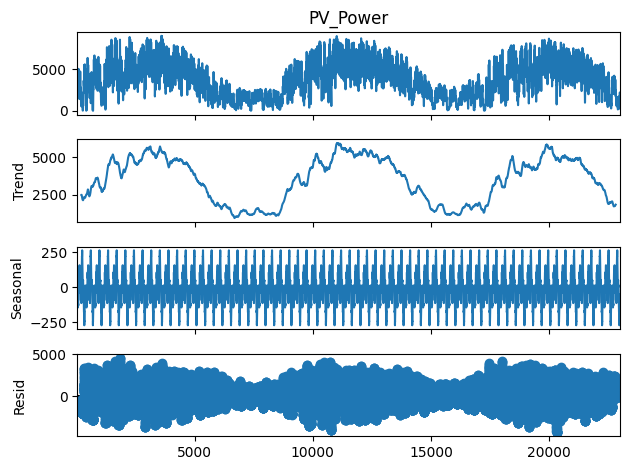

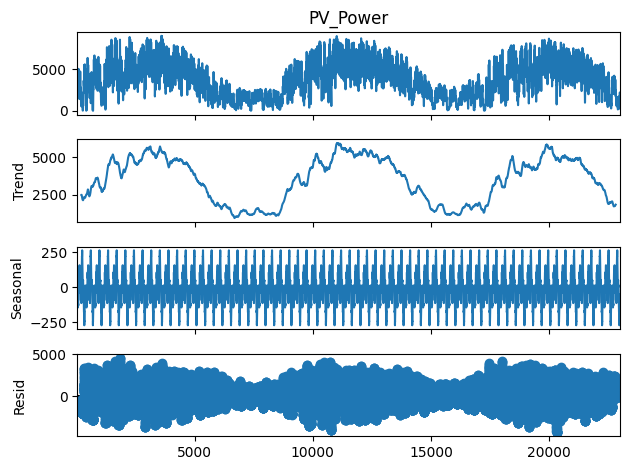

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(daily_data_smooth, model='additive', period=365).plot()

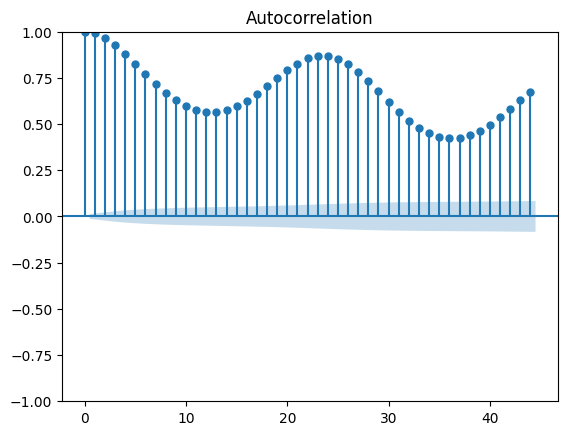

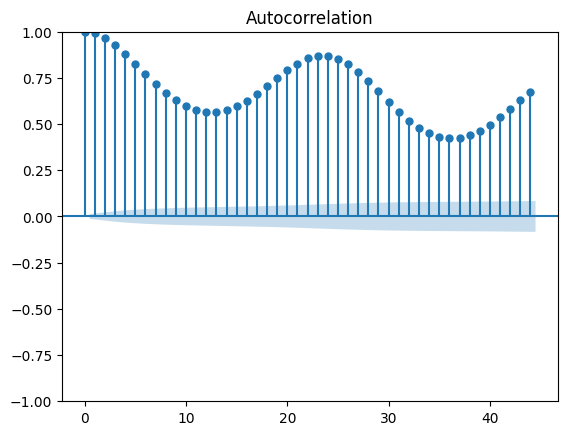

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(daily_data_smooth)

In [9]:
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def build_stacked_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

def build_cnn_1d(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    return model

def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

models = {
    '1D CNN': build_cnn_1d,
    'LSTM': build_lstm,
    'Stacked LSTM': build_stacked_lstm,
    'GRU': build_gru
}

In [10]:
scaler = MaxAbsScaler()
scaled_series = scaler.fit_transform(daily_data_smooth.values.reshape(-1, 1))

In [12]:
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 12
X, y = create_dataset(scaled_series, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

tscv = TimeSeriesSplit(n_splits=5)

In [13]:
# Metrics lists and predictions for plotting
all_y_tests = {}
all_y_preds = {}

# Iterate over different models
for model_name, model_builder in models.items():
    print(f"\nTraining {model_name} model...")
    mse_list, rmse_list, mae_list, r2_list = [], [], [], []
    all_y_test, all_y_pred = [], []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Model definition
        model = model_builder((time_step, X.shape[2]))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Model training
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Predictions
        y_pred = model.predict(X_test)

        # Metrics calculation
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred.flatten())

    # Store true and predicted values for plotting
    all_y_tests[model_name] = all_y_test
    all_y_preds[model_name] = all_y_pred

    # Printing metrics for each fold
    for i in range(len(mse_list)):
        print(f"{model_name} - Fold {i+1} - MSE: {mse_list[i]}, RMSE: {rmse_list[i]}, MAE: {mae_list[i]}, R2: {r2_list[i]}")

    # Calculating and printing mean and standard deviation of metrics
    print(f"\n{model_name} - Average Metrics and Standard Deviations:")
    print(f"MSE: Mean = {np.mean(mse_list)}, Std = {np.std(mse_list)}")
    print(f"RMSE: Mean = {np.mean(rmse_list)}, Std = {np.std(rmse_list)}")
    print(f"MAE: Mean = {np.mean(mae_list)}, Std = {np.std(mae_list)}")
    print(f"R2: Mean = {np.mean(r2_list)}, Std = {np.std(r2_list)}")



Training 1D CNN model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1D CNN - Fold 1 - MSE: 0.0003983827724406808, RMSE: 0.019959528362180325, MAE: 0.01478345540904586, R2: 0.9890863753910121
1D CNN - Fold 2 - MSE: 0.00028415079557606585, RMSE: 0.01685677298821058, MAE: 0.01251075656789098, R2: 0.9946358265143492
1D CNN - Fold 3 - MSE: 0.0003040381962931907, RMSE: 0.017436691093587416, MAE: 0.012983629689521074, R2: 0.9922371262244213
1D CNN - Fold 4 - MSE: 0.00021638735085350674, RMSE: 0.014710110497664752, MAE: 0.010529067829955753, R2: 0.9941721159177267
1D CNN - Fold 5 - MSE: 0.0003064262305974564, RMSE: 0.017505034435768937, MAE: 0.012827761943679065, R2: 0.9922174882478092

1D CNN - Average Metrics and Standard Deviations:
MSE: Mean = 0.00030187706915218006, Std = 5.824333235189192e-05
RMSE: Mean = 0.017293627475482402, Std = 0.0016755649469418507
MAE: Mean = 0.012726934288018549, Std = 0.0013551891115772014
R2: Mean = 0.9924697864590637, Std = 0.0019572894898064273

Training LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM - Fold 1 - MSE: 8.795761574220763e-05, RMSE: 0.009378572159033998, MAE: 0.007480640572322136, R2: 0.9975904168901907
LSTM - Fold 2 - MSE: 7.506716027637707e-05, RMSE: 0.008664130670550685, MAE: 0.006771166216347586, R2: 0.9985828888144365
LSTM - Fold 3 - MSE: 0.0001542050754474899, RMSE: 0.012417933622285549, MAE: 0.009721273529796178, R2: 0.9960627495135576
LSTM - Fold 4 - MSE: 6.451827892386115e-05, RMSE: 0.00803232711758312, MAE: 0.006550762015549541, R2: 0.9982623519846565
LSTM - Fold 5 - MSE: 8.203413112429738e-05, RMSE: 0.009057269518143831, MAE: 0.006847185766461008, R2: 0.9979165243513559

LSTM - Average Metrics and Standard Deviations:
MSE: Mean = 9.275645230284662e-05, Std = 3.169932421470036e-05
RMSE: Mean = 0.009510046617519436, Std = 0.0015216654150810379
MAE: Mean = 0.00747420562009529, Std = 0.0011652915506659791
R2: Mean = 0.9976829863108394, Std = 0.0008756443905206599

Training Stacked LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



KeyboardInterrupt: 

In [ ]:
def plot_predictions(dates, actual_values, all_y_preds, window=5):
    """
    Plot comparison of actual and predicted values for each model.

    Args:
        dates (list): List of dates corresponding to the actual and predicted values.
        actual_values (list): List of actual values for the test set.
        all_y_preds (dict): Dictionary of predicted values for each model (model name -> y_pred list).
        window (int): Window size for smoothing the actual and predicted values.

    Returns:
        None
    """
    fig = go.Figure()
    # Smoothing actual values using rolling mean
    actual_smooth = pd.Series(actual_values).rolling(window=window).mean()

    # Adding actual values to the plot
    fig.add_trace(go.Scatter(
        x=dates,
        y=actual_smooth,
        mode='lines',
        name='Actual Values',
        line=dict(dash='dot')
    ))

    for model_name in all_y_preds.keys():
        # Smoothing predicted values using rolling mean
        y_pred_smooth = pd.Series(all_y_preds[model_name]).rolling(window=window).mean()

        # Adding predicted values to the plot
        fig.add_trace(go.Scatter(
            x=dates,
            y=y_pred_smooth,
            mode='lines',
            name=f'{model_name} - Predictions'
        ))

    fig.update_layout(
        title='Comparison of Actual and Predicted Values',
        xaxis_title='Date',
        yaxis_title='Value',
        legend_title='Models',
        template='plotly_white'
    )
    fig.show()

In [ ]:
dates = data2['DATE'][-len(y):]
plot_predictions(dates, all_y_tests['LSTM'], all_y_preds, window=1024)

Output hidden; open in https://colab.research.google.com to view.